In [78]:
import pandas as pd
import numpy as np
import datetime as dt
import pylab as pl
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
import seaborn as sns
import itertools
import scipy.stats as scs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from IPython.display import HTML, display
from collections import Counter

In [79]:
df = pd.read_csv("IS.csv")

In [80]:
df.columns = df.columns.str.lstrip()

In [81]:
df.columns = df.columns.str.lower()

In [82]:
df.columns = df.columns.str.replace(" ", "_")

In [83]:
df.columns

Index([u'activity_type', u'user_id', u'rm_id', u'user_os', u'viewing_app',
       u'viewing_app_version', u'user_groups', u'shared_date', u'shared_time',
       u'title_of_content', u'share_channel', u'viewed',
       u'time_spent_in_seconds', u'last_activity_date', u'last_activity_time'],
      dtype='object')

# EDA & Feature Engineering

In [84]:
df.user_os.unique()


array(['WINDOWS_7', nan, 'WINDOWS_10', 'MAC_OS_X', 'MAC_OS_X_IPHONE',
       'WINDOWS_81', 'MAC_OS_X_IPAD', 'ANDROID6', 'UBUNTU',
       'ANDROID_MOBILE', 'LINUX', 'ANDROID5', 'ANDROID4', 'iOS9_IPHONE',
       'WINDOWS_XP'], dtype=object)

In [87]:
df.rename(columns={'user_os': 'viewing_device'}, inplace=True)
df["viewing_device"].replace({"WINDOWS_7" : "Laptop/Desktop", "WINDOWS_10" : "Laptop/Desktop", "WINDOWS_81" : "Laptop/Desktop", "WINDOWS_XP" : "Laptop/Desktop", "LINUX" : "Laptop/Desktop", "UBUNTU" : "Laptop/Desktop", "MAC_OS_X" : "Laptop/Desktop"}, inplace = True)
df["viewing_device"].replace({"ANDROID_MOBILE" : "Phone", "ANDROID6" : "Phone", "ANDROID4" : "Phone", "ANDROID5" : "Phone","ANDROID7" : "Phone", "MAC_OS_X_IPHONE" : "Phone", "iOS7_IPHONE" : "Phone", "iOS8_1_IPHONE" : "Phone", "iOS8_3_IPHONE" : "Phone", "iOS9_IPHONE" : "Phone"}, inplace=True)
df["viewing_device"].replace({"ANDROID4_TABLET" : "Tablet", "ANDROID6_TABLET" : "Tablet", "iOS8_1_IPAD" : "Tablet", "MAC_OS_X_IPAD" : "Tablet"}, inplace = True)


In [88]:
df.viewing_app.unique()

array(['CHROME', 'CHROME51', 'IE11', nan, 'SAFARI', 'EDGE14', 'CHROME49',
       'MOBILE_SAFARI', 'FIREFOX', 'CHROME45', 'EDGE', 'CHROME47',
       'EDGE13', 'IE10', 'CHROME33', 'CHROME48', 'CHROME_MOBILE',
       'CHROME42', 'FIREFOX43', 'FIREFOX47', 'EDGE12', 'IE7', 'SAFARI9',
       'CHROME38', 'FIREFOX44', 'FIREFOX37', 'APPLE_WEB_KIT', 'CHROME30'], dtype=object)

In [89]:
df.rename(columns={'viewing_app': 'browser'}, inplace=True)
df["browser"].replace({"CHROME45" : "CHROME", "CHROME51" : "CHROME", "CHROME33" : "CHROME", "CHROME30" : "CHROME", "CHROME47" : "CHROME", "CHROME49" : "CHROME", "CHROME42" : "CHROME", "CHROME48" : "CHROME", "CHROME38" : "CHROME", "FIREFOX44" : "FIREFOX", "FIREFOX47" : "FIREFOX", "FIREFOX43" : "FIREFOX", "FIREFOX37" : "FIREFOX", "EDGE12" : "EDGE"}, inplace = True)
df["browser"].replace({"EDGE13" : "EDGE", "EDGE14" : "EDGE", "IE7" : "IE", "IE10" : "IE", "IE11" : "IE", "SAFARI9" : "SAFARI", "APPLE_WEB_KIT" : "SAFARI"}, inplace=True)
df.browser.unique()

array(['CHROME', 'IE', nan, 'SAFARI', 'EDGE', 'MOBILE_SAFARI', 'FIREFOX',
       'CHROME_MOBILE'], dtype=object)

In [90]:
df["shared_date"] = pd.to_datetime(df["shared_date"], format="%d-%b-%Y")

In [91]:
df["last_activity_date"] = pd.to_datetime(df["last_activity_date"], format="%d-%b-%Y")

In [92]:
df['weekday'] = df['last_activity_date'].dt.dayofweek
df["weekday_name"] = df['last_activity_date'].dt.weekday_name
df["month"] = df['last_activity_date'].dt.month
df["time_of_day"] = pd.to_datetime(df['last_activity_time'], format='%H:%M:%S').dt.hour
df.time_of_day.unique()

array([20, 12, 11,  8,  7, 15,  5,  0, 23, 22, 21, 19, 10,  9, 14, 13,  6,
        4,  3,  2,  1, 18, 17, 16])

In [93]:
# 1: Night(Midnight to 6 am), 2: Morning(6 am to Noon), 3: Afternoon(Noon to 6 pm), 4: Evening(6 pm to Midnight)
df["time_of_day"].replace({0 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1}, inplace = True)
df["time_of_day"].replace({6 : 2, 7 : 2, 8 : 2, 9 : 2, 10 : 2, 11 : 2}, inplace = True)
df["time_of_day"].replace({12 : 3, 13 : 3, 14 : 3, 15 : 3, 16 : 3, 17 : 3}, inplace = True)
df["time_of_day"].replace({18 : 4, 19 : 4, 20 : 4, 21 : 4, 22 : 4, 23 : 4,}, inplace = True)
df.time_of_day.unique()

array([4, 3, 2, 1])

In [94]:
df['hour'] = pd.to_datetime(df['last_activity_time'], format='%H:%M:%S').dt.hour

In [95]:
df.viewed.unique()

array([1, 0])

In [96]:
df["time_spent_mins"] = df["time_spent_in_seconds"]/60.

In [97]:
hour_grouped = df.groupby("time_of_day")["time_spent_mins"].sum()

In [98]:
# plot = plt.bar(xrange(0,4),(df.groupby("time_of_day")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])


In [99]:
#sns.distplot(df["time_spent_mins"], color="m")
len(df)

3661

3258

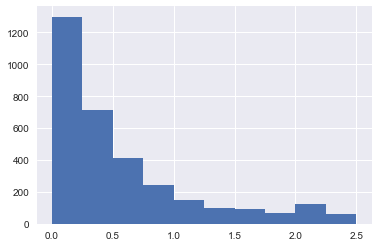

In [104]:
df = df[df["time_spent_mins"] <= 2.5]
plot = plt.hist(df["time_spent_mins"])
#plt.boxplot(new_df["time_spent_mins"])

len(df) 
# 1917 (22% reduced)
#sns.distplot(new_df["time_spent_mins"], color="g")

# SHARE DATA ANALYSIS

In [105]:
share_df = df[df.activity_type == "SHARE"]
share_df.columns

Index([u'activity_type', u'user_id', u'rm_id', u'viewing_device', u'browser',
       u'viewing_app_version', u'user_groups', u'shared_date', u'shared_time',
       u'title_of_content', u'share_channel', u'viewed',
       u'time_spent_in_seconds', u'last_activity_date', u'last_activity_time',
       u'weekday', u'weekday_name', u'month', u'time_of_day', u'hour',
       u'time_spent_mins'],
      dtype='object')

In [106]:
y_time_spent = share_df.groupby("weekday")["time_spent_mins"].sum

In [107]:
#sns.stripplot(x=share_df["weekday_name"], y=share_df["time_spent_mins"], data=share_df, jitter=True)

In [108]:
len(share_df), len(share_df.user_id.unique())

(905, 383)

In [109]:
share_df['num_of_day_from_share_view'] = (share_df["last_activity_date"] - share_df["shared_date"]).astype(dt.timedelta).map(lambda x: 0 if pd.isnull(x) else x.days)
share_df["num_of_day_from_share_view"].unique()

# sns.distplot(share_df["num_of_day_from_share_view"], color="m")

/Users/urmimukherjee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([  0,   2,   1,  70,  99,  82,  15,   4, 124,   8,  13,  65,  18,
        50, 358,  60,   5,   3,  40, 147,  22,   7,  57, 296,  12,  14,
       122,  25, 278,  28,  68, 175,  44,  84,  47,  17,   6,  11, 126,
        52,  19, 214,  77,   9])

([<matplotlib.axis.XTick at 0x1158c4350>,
 <a list of 7 Text xticklabel objects>)

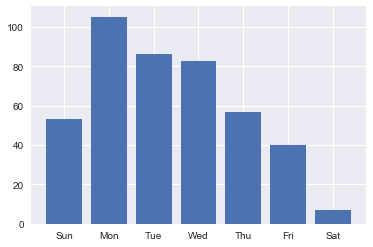

In [110]:
plt.bar(xrange(0,7), share_df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

(array([  2.69968019e-02,   3.03619140e-04,   2.02412760e-04,
          1.26507975e-04,   1.26507975e-04,   7.59047850e-05,
          0.00000000e+00,   2.53015950e-05,   2.53015950e-05,
          5.06031900e-05]),
 array([   0. ,   35.8,   71.6,  107.4,  143.2,  179. ,  214.8,  250.6,
         286.4,  322.2,  358. ]),
 <a list of 10 Patch objects>)

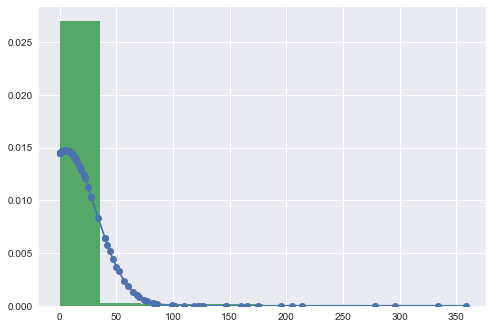

In [27]:
import pylab as pl
h = sorted(share_df["num_of_day_from_share_view"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)

(905, 844)

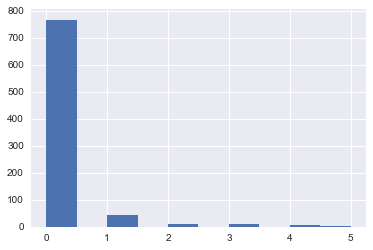

In [119]:
import pylab as pl
days_share_view = share_df[share_df["num_of_day_from_share_view"]<=5]

h = sorted(days_share_view["num_of_day_from_share_view"]) #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

#pl.plot(h,fit,'-o')

pl.hist(h)
len(share_df),len(days_share_view)

In [120]:
# uniq_titles = np.sort(share_df.title_of_content.unique())
# uniq_title_num_share = share_df.groupby("title_of_content")["activity_type"].count()
# #uniq_titles 
# uniq_title_num_share

In [121]:
# import pylab as pl
# h = sorted(share_df["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')

# pl.hist(h,normed=True)


In [122]:
#share_df["weekday"].plot.kde()

In [123]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("weekday")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# share_weekday = share_df.groupby("weekday")["time_spent_mins"].sum()

In [124]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("month")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

In [125]:
# import pylab as pl
# new_share = share_df[share_df["time_spent_mins"]<=8]
# h = sorted(new_share["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')
# pl.axvline(x=np.mean(h)+np.std(h),color='r', linestyle='--')
# pl.axvline(x=np.mean(h)-np.std(h),color='r', linestyle='--')
# pl.hist(h,normed=True)


In [126]:
#h = plt.hist(share_df.time_spent_mins)

In [127]:
#sns.stripplot(x="share_channel", y="time_spent_mins", data=share_df)
df.share_channel.unique()


array([nan, 'WEB', 'OUTLOOK'], dtype=object)

([<matplotlib.axis.XTick at 0x1164686d0>,
 <a list of 2 Text xticklabel objects>)

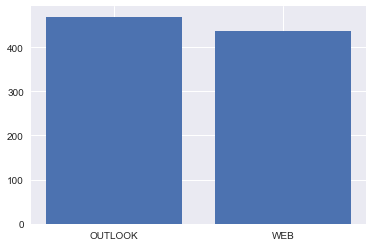

In [128]:
plt.bar(xrange(0,2),(share_df.groupby("share_channel")["time_spent_mins"].count()))
plt.xticks(xrange(0,2),["OUTLOOK","WEB"])
# plt.xlabel("Share Channel")
# plt.ylabel("Number of Shares")
# plt.title("TW - Num Shares Vs Share Channel")

In [129]:
#sns.stripplot(x="time_of_day", y="time_spent_mins", data=share_df)


# VIEW DATA ANALYSIS

In [130]:
view_df = df[(df.activity_type == "VIEW")]
view_df = view_df.drop(["share_channel", "user_groups", "shared_date", "shared_time", "rm_id"], axis =1)


In [131]:
len(view_df), len(view_df.user_id.unique())

(2353, 356)

In [132]:
len(view_df.title_of_content.unique())


252

In [133]:
#view_df.head()

2353

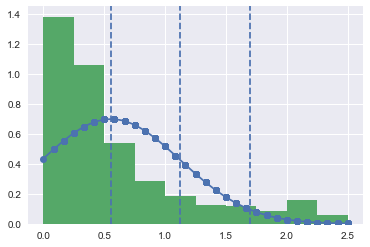

In [136]:
#### import pylab as pl
new_view = view_df[view_df["time_spent_mins"] <= 4]
len(new_view) #(20 mins, 1874/2085, 10% reduced) (12 mins, 1746/2085, 16% reduced)(6 mins, 1607/2085, 23% reduced)
# (4 mins, 1513/2085, 28% reduced)

h = sorted(new_view["time_spent_mins"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h, normed= True)

pl.axvline(x = np.mean(h), linestyle='--')
pl.axvline(x = np.mean(h) + np.std(h), linestyle='--')
pl.axvline(x = np.mean(h) + 2*np.std(h), linestyle='--')
len(new_view)

In [137]:
#(view_df.groupby("view_app_group")["time_spent_mins"].sum()).plot.kde()


(array([ 813.,  624.,  317.,  168.,  110.,   73.,   71.,   50.,   92.,   35.]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ]),
 <a list of 10 Patch objects>)

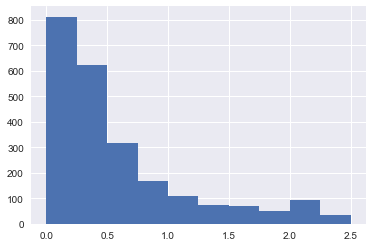

In [138]:
plt.hist(view_df["time_spent_mins"])

(array([ 813.,  624.,  317.,  168.,  110.,   73.,   71.,   50.,   92.,   35.]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ]),
 <a list of 10 Patch objects>)

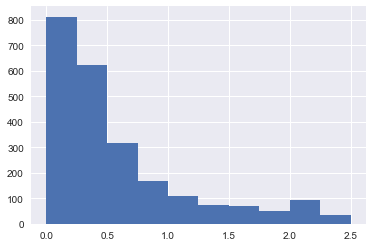

In [139]:
plt.hist(new_view["time_spent_mins"])

In [142]:
from collections import Counter
user_id_list = [j.user_id for i,j in df.iterrows() if j["activity_type"] == "VIEW"]
num_views = Counter(user_id_list)
best, views = [], []
#best = sorted(num_views, key=lambda x : num_views[x])
for w in sorted(num_views, key=num_views.get, reverse=True):
    best.extend([w, num_views[w]]), views.append(num_views[w])
np.array(views).mean(), np.array(views).std()

(6.6095505617977528, 13.895347973463036)

(array([ 226.,   70.,   14.,    8.,    1.,    6.,    3.,    6.,    4.,
           2.,    3.,    1.,    2.,    0.,    1.,    0.,    1.,    0.,
           1.,    1.,    0.,    0.,    2.,    0.,    1.,    1.,    1.,
           1.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.]),
 array([   1.   ,    3.975,    6.95 ,    9.925,   12.9  ,   15.875,
          18.85 ,   21.825,   24.8  ,   27.775,   30.75 ,   33.725,
          36.7  ,   39.675,   42.65 ,   45.625,   48.6  ,   51.575,
          54.55 ,   57.525,   60.5  ,   63.475,   66.45 ,   69.425,
          72.4  ,   75.375,   78.35 ,   81.325,   84.3  ,   87.275,
          90.25 ,   93.225,   96.2  ,   99.175,  102.15 ,  105.125,
         108.1  ,  111.075,  114.05 ,  117.025,  120.   ]),
 <a list of 40 Patch objects>)

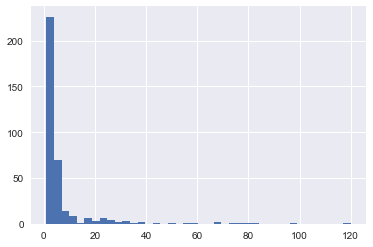

In [141]:
plt.hist(views, bins = 40)

In [62]:
sorted(view_df.browser.unique())

[nan,
 'CHROME',
 'CHROME_MOBILE',
 'EDGE',
 'FIREFOX',
 'IE',
 'MOBILE_SAFARI',
 'SAFARI']

([<matplotlib.axis.XTick at 0x1139ea650>,
 <a list of 9 Text xticklabel objects>)

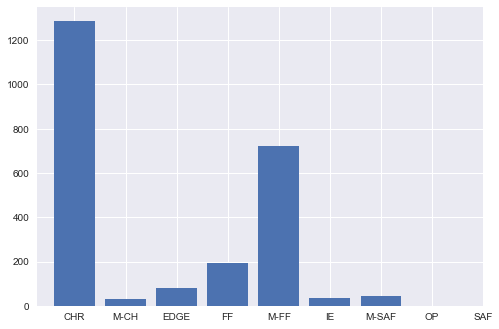

In [47]:
plt.bar(xrange(0,len(view_df.groupby("browser")["time_spent_mins"].sum())), view_df.groupby("browser")["time_spent_mins"].sum())
plt.xticks(xrange(0,9),['CHR',"M-CH",'EDGE', "FF", 'M-FF', 'IE', 'M-SAF', "OP",'SAF'])
# plt.xlabel("Viewing Application")
# plt.ylabel("Total View Time in Minutes")
# plt.title("Time Spent Vs View App")

([<matplotlib.axis.XTick at 0x1142b12d0>,
 <a list of 9 Text xticklabel objects>)

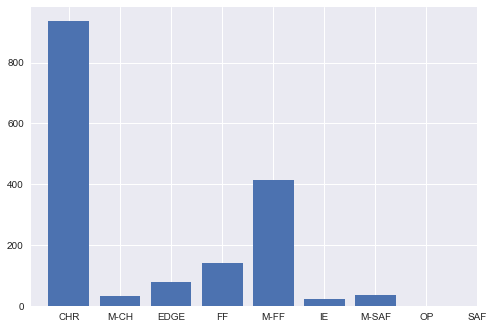

In [64]:
plt.bar(xrange(0,len(new_view.groupby("browser")["time_spent_mins"].sum())), new_view.groupby("browser")["time_spent_mins"].sum())
plt.xticks(xrange(0,9),['CHR',"M-CH",'EDGE', "FF", 'M-FF', 'IE', 'M-SAF', "OP",'SAF'])

([<matplotlib.axis.XTick at 0x113895250>,
 <a list of 4 Text xticklabel objects>)

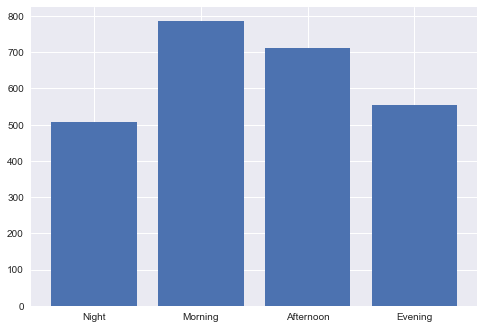

In [48]:
plt.bar(xrange(0,4), view_df.groupby("time_of_day")["time_spent_mins"].count())
plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])
# plt.xlabel("Time of Day")
# plt.ylabel("Total View Time in Minutes")
# plt.title("TW - Time Spent Vs Time of Day")

([<matplotlib.axis.XTick at 0x113bf8850>,
 <a list of 4 Text xticklabel objects>)

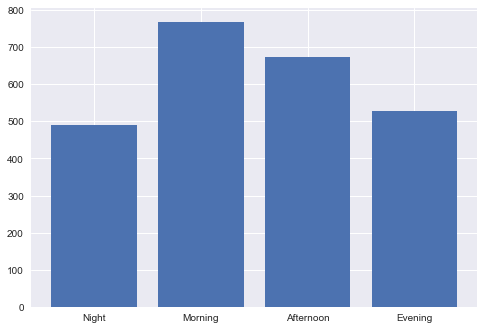

In [65]:
plt.bar(xrange(0,4), new_view.groupby("time_of_day")["time_spent_mins"].count())
plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])

In [49]:
def get_view_time_per_user(unique_users, view_df):
    for user in unique_users:
        temp_time = view_df["user_id"]

([<matplotlib.axis.XTick at 0x113f10f10>,
 <a list of 7 Text xticklabel objects>)

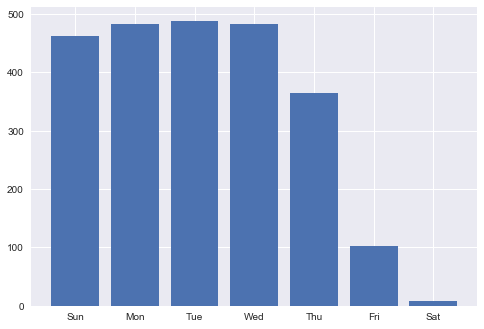

In [50]:
plt.bar(xrange(0,7), view_df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
#plt.xlabel("Day of Week")
#plt.ylabel("Total View Time in Minutes")
#plt.title("TW - Time Spent Vs Day of Week")

([<matplotlib.axis.XTick at 0x114763910>,
 <a list of 7 Text xticklabel objects>)

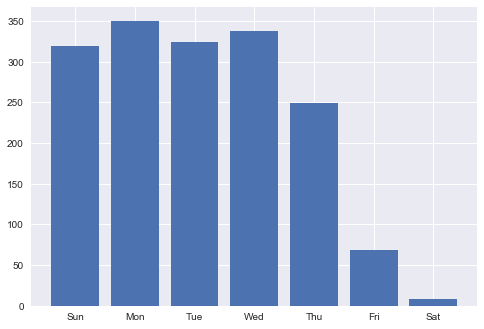

In [68]:
plt.bar(xrange(0,7), new_view.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])


In [51]:
# Get the time spent on different apps
# def get_time_spent(view_df):
#     time_spent_secs = view_df["time_spent_in_seconds"].sum()
#     view_apps = view_df["view_app_group"].unique()

#     time_spent_dict = {}
#     for v in view_apps:
#         temp_time = view_df[view_df.view_app_group == v]["time_spent_in_seconds"].sum()
#         time_spent_dict[v] = [temp_time, float(temp_time)*100/time_spent_secs]
#     return time_spent_dict

# get_time_spent(view_df)

([<matplotlib.axis.XTick at 0x114123950>,
 <a list of 3 Text xticklabel objects>)

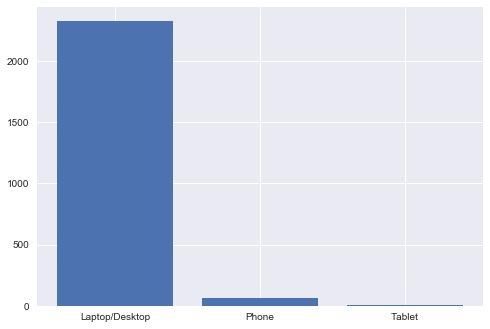

In [52]:
plt.bar(xrange(0,3), view_df.groupby("viewing_device")["time_spent_mins"].sum())
plt.xticks(xrange(0,3),["Laptop/Desktop", "Phone", "Tablet"])

In [53]:
#sns.stripplot(x="view_app_group", y="time_spent_mins", data=view_df)
#plt.bar(xrange(0,8), view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [54]:
#sns.boxplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [55]:
#sns.barplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [56]:
#sns.countplot(x="view_app_group", data=view_df, hue = "view_app_group")


In [57]:
#plt.bar(xrange(0,9),view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [58]:
#sns.stripplot(x=view_df["view_app_group"], y=view_df["time_spent_mins"], data=view_df, jitter=True)


In [59]:
#sns.stripplot(x=view_df["weekday"], y=view_df["time_spent_mins"], data=view_df, jitter=True)



([<matplotlib.axis.XTick at 0x1138b79d0>,
 <a list of 6 Text xticklabel objects>)

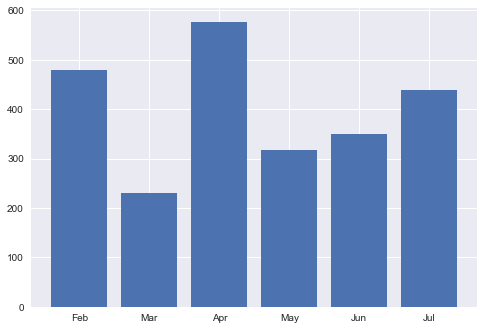

In [60]:
plt.bar(xrange(0,len(view_df.groupby("month")["time_spent_mins"].sum())), view_df.groupby("month")["time_spent_mins"].sum())
plt.xticks(xrange(0,6),["Feb", "Mar", "Apr", "May", "Jun", "Jul"])

In [61]:
# clusterer = KMeans(n_clusters=7, random_state=10)
# clusterer.fit(X)

